# Document Classification

In the previous activity, we have demonstrated the basic steps of text pre-processing with the BBC News corpus. 
We have also saved all the tokenized text, the vocabulary and the generated data features in .txt files. 
In this activity, we are going to have a bit of fun buliding maching leaning models for document classification, using our generated data features. 

## The Dataset
Same as in the previous activity, the document collection that we are going to use is the BBC News Dataset. For the origin of the dataset, please refer to the previous activity. 
To be brief, the dataset:
* Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
* Class Labels: 5 (business, entertainment, politics, sport, tech)

Instead of using the raw text data from the dataset, in this activity, we will utilised the generated data features from the previous activity (and that's the reason why we put this two activities in the same folder  &#129322;). You must complete the previous activity before you start with this activity. Before you start, make sure you have the following files in the same folder as this Jupyter Notebook:
- `articles` folder consist of 2225 BBC News articles, each in a .txt file, named with its article ID (in a 4 digit format: '0001.txt' - '2225.txt'). This folder is obtained from the original dataset;
- `labels.csv` is a csv file with two columns, one is the `Article ID` (in 4 digit format), and another is its corresponding class labels, i.e., one of the 5 (business, entertainment, politics, sport, tech). This file is from the original dataset;
- `jobAd_bVector.txt` stores the binary vector representation in the format of `word_index:1` for words that appear in a document;
- `jobAd_cVector.txt` stores the count vector representation in the format of `word_index:count` for words that appear in a document;
- `jobAd_tVector.txt` stores the tfidf vector representation in the format of `word_index:weight` for words that appear in a document;
- `jobAd_Webindexs.txt` stores the IDs of articles, with same indexes as the previous files storing the vector representations;
- `jobAd_voc.txt` stores the vocabulary (as well as the index of each word).

Before we start to do anything interesting, let's read the data first. 
We will first take a look at the lables and their distribution:

In [9]:
import pandas as pd

from itertools import chain
from nltk.probability import *

# import code as a function
from src.utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# set desired matplotlib gloabal figure size
plt.rcParams["figure.figsize"] = (20,10)

## 1. Reading Data Files
### 1.1 Reconstructing the Vector Representation

Recall that in the previous activity, we have processed the BBC News articles, each converts to three vector representation: binary vector, count vector and tfidf vector. 
We have also saved these representations in files: 
* each line represents an article/document
* each article is saved as a sequence of entries that correspond to the tokens, i.e. `word_index:word_count` or `word_index:weight` (for tfidf vector)


Now, we will have to read these pre-processed data and reconstruct the vector representation for each document, and thus, re-construct the matrix represenstation for the entire corpus that is ready for downstream analysis tasks. 

In the following, we defined two functions:

* `str2vec` takes a string (i.e. a line in a vector representation file), and the size of the vocabulary as inputs. It then constructs a document vector of the vocabulary size, process the string, and enters values (count/weight) into the relevant element of the document vector and returns the constructed document vector. 
* `vecF2matrix` takes the names of the files of the vector representation (e.g. `jobAd_bVector.txt`) and the size of vocabulary as inputs, then:
    * it reads the vector representation file as a list of lines (one of each article), then constructs the matrix represenstation (list of lists, each row is an article, and each column is a word index) for the entire corpus
    * finally, it convert the constructed sparse matrix into a CSR matrix representation using the `csr_matrix` function from `scipy.sparse`

In [27]:
def str2vec(vec_str,voc_size): # doc_vec is a string of the format `word_index:value word_index:value word_index:value ...''
    doc_vec = [0] * voc_size # construct a document vector of the vocabular size
    # processing the vec_str
    for pair in vec_str.split(' '): # split with ' ' such that each pair is an entry `word_index:value`
        w_ind = int(pair.split(':')[0]) # split with ':' to get the word_index from the 1st element
        w_freq = float(pair.split(':')[1]) # split with ':' to get the value from the 2nd element
        doc_vec[w_ind] = w_freq # write the value to the element on the word_index
    return doc_vec

In [28]:
from scipy.sparse import csr_matrix

def vecF2matrix(vec_fname,voc_size): # return the matrix representaion for the corpus
    with open(vec_fname) as vecf:
        vec_strings = vecf.readlines() # reading a list of strings, each for a document/article
    doc_vectors = [str2vec(vstr.strip(),voc_size) for vstr in vec_strings] # construct the matrix representation for the corpus                                                                  # by calling the 'str2vec' function for each line/string
    return csr_matrix(doc_vectors) # convert the sparse matrix into csr format and return the obtain csr matrix

Then, we can use the above functions to read in the pre-processed data files and re-constructed the document vector for each article.
We first read the vocabulary files and calculates the size of the vocabulary based on the number of lines in the vocabulary file (recall, each line in the file stores a single word and its index).

In [29]:
voc_fname = 'vocab.txt'
with open(voc_fname) as vocf: 
    voc_size = len(vocf.readlines()) # the number of lines corresponds to the size of the vocabulary

In [30]:
# reconstructing the binary vector representations
binary_features = vecF2matrix('./jobAd_bVector.txt',voc_size)

In [31]:
# reconstructing the count vector representations
count_features = vecF2matrix('./jobAd_cVector.txt',voc_size)

In [32]:
# reconstructing the tfidf vector representations
tfidf_features = vecF2matrix('./jobAd_tVector.txt',voc_size)

Now we have reconstructed the vector representation (binary, count and tfidf) of each article and we are ready to move on to explore the analysis task &#128522;

### 1.2 Labels
Let's have a look at the label data `labels.csv` file, we can easily read it in using pandas funciton `read_csv`.

In [33]:
# Read job_ad.csv
job_ad = pd.read_csv('job_ad.csv')

# # get the description of the job ad
# description = job_ad['Description']
# # get the tokenized description of the job ad
# tk_description = job_ad['Tokenized Description']
webindex = job_ad['Webindex']


# print first 3 rows
job_ad.head(3)

,Title,Webindex,Company,Description,Tokenized Description,Category
0,Finance / Accounts Asst Bromley to ****k,68997528,First Recruitment Services,Accountant (partqualified) to **** p.a. South ...,"['accountant', 'partqualified', 'south', 'east...",Accounting_Finance
1,Fund Accountant Hedge Fund,68063513,Austin Andrew Ltd,One of the leading Hedge Funds in London is cu...,"['leading', 'hedge', 'funds', 'london', 'recru...",Accounting_Finance
2,Deputy Home Manager,68700336,Caritas,An exciting opportunity has arisen to join an ...,"['exciting', 'opportunity', 'arisen', 'join', ...",Healthcare_Nursing


In [34]:
labels_df = job_ad[['Webindex', 'Category']]
labels_df.head()

,Webindex,Category
0,68997528,Accounting_Finance
1,68063513,Accounting_Finance
2,68700336,Healthcare_Nursing
3,67996688,Accounting_Finance
4,71803987,Healthcare_Nursing


In [35]:
labels_df.sample(5)

,Webindex,Category
162,70593580,Accounting_Finance
235,68691974,Accounting_Finance
655,69065735,Accounting_Finance
314,71838397,Accounting_Finance
34,70762357,Engineering


Let's have a look the distribution of these labels, i.e. how many articles of a particular category.

                    Webindex
Category                    
Accounting_Finance       191
Engineering              231
Healthcare_Nursing       198
Sales                    156


<AxesSubplot:xlabel='Category'>

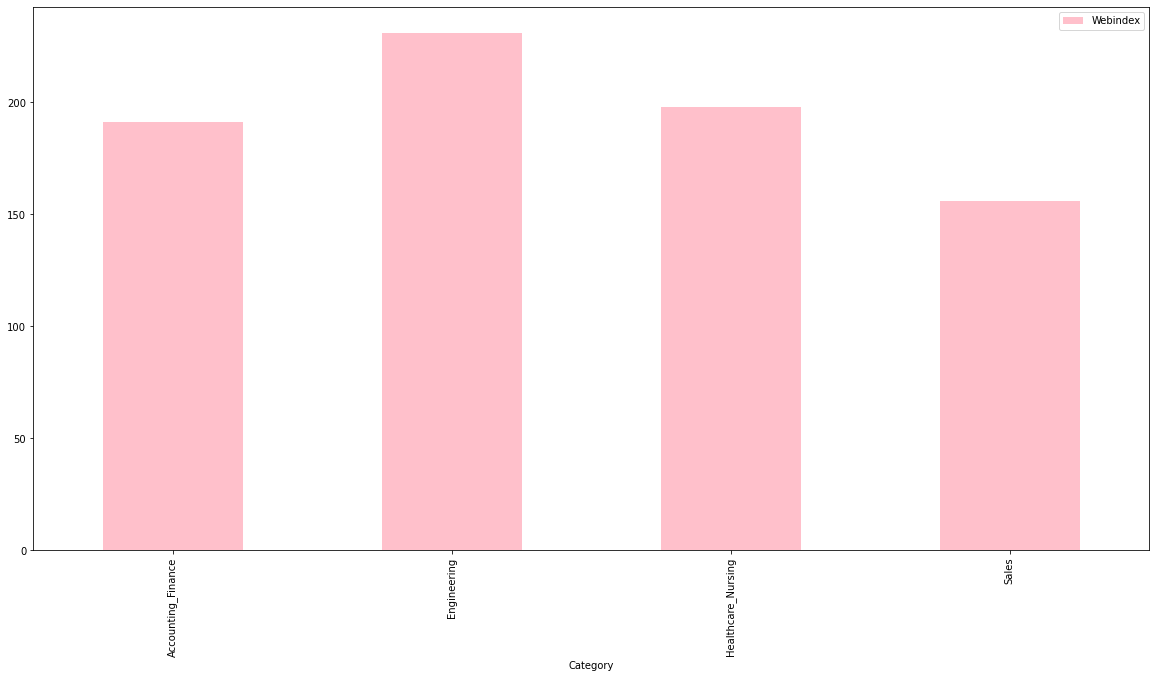

In [36]:
stats = labels_df.groupby('Category').count()
print(stats)
stats.plot.bar(ylim=0, color='pink')

Oh, good, it seems they more or less have similar number of articles in each category. In Machine Learning, we will say our data is relatively balanced, which is a lucky thing to have &#128516;

## 2.3 Creating List of Labels

Now we have read in the article ID and its associated labels into a pandas dataframe, however, all our data features are orderded in a different way (in a list). 
We will have to construct a list of labels in which the order corresponds to the data features. 
Thank ourselves that we have saved the article IDs in a .txt file `jobAd_Webindexs.txt` in our previous activity. In this file, each line is an article ID, and the order corresponds exactly to how we've saved our data features.

In the following, we define a function `gen_labels` which takes the name of the file we've saved our article IDs, and the labels dataframe as inputs, it then:
* creates an empty list of labels
* read all the article_ids into a list
* then for each extracted article ID, we appended the corresponding label to the list of labels, as such, the final order of the labels list correspond exactly to the order of our data features as well &#128522;

In [37]:
def gen_labels(aid_fname,labels_df):
    labels = [] # create empty label list
    with open(aid_fname) as lf: 
        article_ids = lf.read().splitlines() # read all the article IDs in a list
    for aid in article_ids: # for each document ID
        labels.append(labels_df.loc[labels_df.Webindex == int(aid)].Category.squeeze()) # append the corresponding label to the label list
    return labels,article_ids # return the list of labels and the list of document ids

Note a few things:
* Here we use `read().splitlines()` instead of `readlines()`, as we don't want to have the line breaks (we want to get the article IDs directly. `readlines()` returns lines with additional line breaks, while `lf.read().splitlines()` does not have additional line break. You feel free to try to change it to `readlines()` and see what you will get &#128540;
* Note also that in the above code we have used a `squeeze()` to remove the single-dimensional entries from the returned series from `labels_df.loc[labels_df.Webindex == int(aid)].Category`. To understand better the effect of the squeeze() function, try the following two code input and see what is the difference using the article of ID 100: 

In [38]:
r1 = labels_df.loc[labels_df.Webindex == 100].Category 
print(r1)
print("type of r1:",type(r1))

Series([], Name: Category, dtype: object)
type of r1: <class 'pandas.core.series.Series'>


In [39]:
import numpy as np
r2 = labels_df.loc[labels_df.Webindex == 100].Category.squeeze()
print(r2)
print("type of r1:",type(r2))

Series([], Name: Category, dtype: object)
type of r1: <class 'pandas.core.series.Series'>


Ok, let's construct the list of labels:

In [40]:
labels, article_ids = gen_labels('webindex.txt',labels_df)
labels

['Accounting_Finance',
 'Accounting_Finance',
 'Healthcare_Nursing',
 'Accounting_Finance',
 'Healthcare_Nursing',
 'Engineering',
 'Healthcare_Nursing',
 'Accounting_Finance',
 'Sales',
 'Sales',
 'Accounting_Finance',
 'Accounting_Finance',
 'Engineering',
 'Sales',
 'Engineering',
 'Sales',
 'Sales',
 'Engineering',
 'Sales',
 'Healthcare_Nursing',
 'Healthcare_Nursing',
 'Healthcare_Nursing',
 'Sales',
 'Sales',
 'Accounting_Finance',
 'Healthcare_Nursing',
 'Healthcare_Nursing',
 'Healthcare_Nursing',
 'Accounting_Finance',
 'Healthcare_Nursing',
 'Sales',
 'Engineering',
 'Healthcare_Nursing',
 'Accounting_Finance',
 'Engineering',
 'Sales',
 'Sales',
 'Engineering',
 'Engineering',
 'Accounting_Finance',
 'Healthcare_Nursing',
 'Healthcare_Nursing',
 'Healthcare_Nursing',
 'Healthcare_Nursing',
 'Accounting_Finance',
 'Accounting_Finance',
 'Healthcare_Nursing',
 'Engineering',
 'Sales',
 'Engineering',
 'Engineering',
 'Healthcare_Nursing',
 'Healthcare_Nursing',
 'Sales',
 'Ac

In [41]:
article_ids

['68997528',
 '68063513',
 '68700336',
 '67996688',
 '71803987',
 '70322392',
 '70086531',
 '68684698',
 '70251801',
 '72457901',
 '71851935',
 '70757932',
 '71215909',
 '70205492',
 '70207759',
 '69770990',
 '72232029',
 '71213522',
 '68258357',
 '71841735',
 '71692209',
 '71805092',
 '65101527',
 '68256188',
 '72198878',
 '68573837',
 '67749541',
 '71691899',
 '71139623',
 '72443411',
 '69799351',
 '69078766',
 '68508976',
 '68564061',
 '70762357',
 '71737507',
 '69577820',
 '67304988',
 '72452403',
 '70163439',
 '66544069',
 '71903513',
 '69568022',
 '69191349',
 '71142126',
 '72481557',
 '69539327',
 '72236089',
 '72233918',
 '68546047',
 '68217600',
 '72478300',
 '70598762',
 '71171000',
 '62016897',
 '68177629',
 '71196021',
 '70757636',
 '71793578',
 '70763481',
 '68678164',
 '70599432',
 '66887344',
 '68714905',
 '68257980',
 '62004211',
 '71367580',
 '71556854',
 '72411451',
 '69966126',
 '72438284',
 '72692186',
 '66399629',
 '72444694',
 '72448172',
 '69996401',
 '71443055',

## 2. Document Classification

Now, let's move onto the document classification task,  we have prepared before:
* the data features (binary, count, and tfidf vectors) for all articles, store in lists (`binary_features`, `count_features`, and `tfidf_features`);
* the list of labels.

Before we start to build the document classification model, we need to spilt the dataset into training and test set.
In the following we create a training and test split by using the train_test_split function from `sklearn.model_selection`, you should want to refer to the API [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* the input is the arrays of features and labels
* size of the test set as proportion, we set it as 0.33 (33% of the data)
* random_state: an integer controlling the shuffling applied to the data before applying the split. (This helps to reproduce the results). 

To make the results reproducible, we set a seed and will use that to set random_state in both `train_test_split` and when we build the models later. 
You feel free to try different seeds and see the differences.

In [42]:
seed = 0

In [43]:
from sklearn.model_selection import train_test_split

# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(binary_features, labels, list(range(0,len(labels))),test_size=0.33, random_state=seed)


Note that in the above, we also record the indices of instances we extract in the training set and the test set, you can print out the indices and have a look. 
The purpose of doing this is that later we can know exactly which instances we classified correctly and which we didn't.

In [44]:
train_indices

[518,
 571,
 534,
 573,
 334,
 643,
 229,
 569,
 416,
 477,
 708,
 597,
 688,
 15,
 245,
 703,
 6,
 524,
 345,
 104,
 460,
 408,
 454,
 90,
 487,
 407,
 333,
 218,
 572,
 434,
 205,
 570,
 190,
 504,
 532,
 194,
 494,
 132,
 233,
 173,
 178,
 749,
 586,
 206,
 686,
 96,
 665,
 337,
 447,
 89,
 413,
 179,
 0,
 46,
 171,
 618,
 615,
 107,
 133,
 457,
 223,
 463,
 102,
 108,
 213,
 499,
 632,
 246,
 689,
 473,
 125,
 462,
 556,
 418,
 627,
 224,
 26,
 365,
 471,
 736,
 350,
 3,
 134,
 325,
 366,
 186,
 502,
 295,
 649,
 435,
 758,
 738,
 225,
 635,
 330,
 432,
 332,
 374,
 596,
 527,
 739,
 679,
 522,
 495,
 360,
 397,
 583,
 112,
 467,
 681,
 20,
 65,
 298,
 126,
 259,
 576,
 402,
 339,
 650,
 137,
 511,
 7,
 342,
 710,
 309,
 645,
 538,
 185,
 529,
 353,
 630,
 153,
 54,
 30,
 748,
 690,
 100,
 452,
 698,
 732,
 237,
 673,
 56,
 400,
 60,
 674,
 262,
 730,
 264,
 720,
 468,
 208,
 391,
 485,
 621,
 167,
 38,
 747,
 668,
 634,
 300,
 516,
 505,
 658,
 163,
 124,
 154,
 336,
 59,
 503,
 3

In [45]:
test_indices

[150,
 122,
 546,
 14,
 542,
 279,
 579,
 187,
 766,
 669,
 31,
 142,
 301,
 774,
 247,
 641,
 656,
 399,
 745,
 478,
 490,
 453,
 744,
 648,
 27,
 602,
 582,
 609,
 162,
 506,
 695,
 358,
 614,
 85,
 390,
 773,
 715,
 318,
 222,
 40,
 493,
 489,
 593,
 425,
 8,
 113,
 558,
 401,
 733,
 204,
 202,
 585,
 428,
 666,
 55,
 75,
 263,
 1,
 443,
 458,
 706,
 670,
 667,
 79,
 762,
 103,
 351,
 500,
 769,
 266,
 685,
 451,
 631,
 404,
 728,
 535,
 316,
 680,
 592,
 389,
 691,
 563,
 590,
 302,
 145,
 356,
 355,
 409,
 683,
 18,
 756,
 240,
 760,
 553,
 441,
 50,
 567,
 626,
 561,
 242,
 39,
 241,
 268,
 531,
 10,
 640,
 68,
 258,
 713,
 492,
 415,
 479,
 2,
 768,
 403,
 382,
 417,
 210,
 385,
 283,
 252,
 255,
 717,
 250,
 367,
 331,
 239,
 419,
 702,
 193,
 251,
 671,
 526,
 71,
 49,
 215,
 620,
 501,
 37,
 412,
 48,
 734,
 313,
 474,
 214,
 156,
 76,
 64,
 718,
 52,
 346,
 422,
 757,
 317,
 235,
 299,
 436,
 230,
 118,
 253,
 157,
 278,
 172,
 198,
 310,
 575,
 97,
 536,
 587,
 175,
 476,
 

## 2. Document Classification

Now, let's move onto the document classification task,  we have prepared before:
* the data features (binary, count, and tfidf vectors) for all articles, store in lists (`binary_features`, `count_features`, and `tfidf_features`);
* the list of labels.

Before we start to build the document classification model, we need to spilt the dataset into training and test set.
In the following we create a training and test split by using the train_test_split function from `sklearn.model_selection`, you should want to refer to the API [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* the input is the arrays of features and labels
* size of the test set as proportion, we set it as 0.33 (33% of the data)
* random_state: an integer controlling the shuffling applied to the data before applying the split. (This helps to reproduce the results). 

To make the results reproducible, we set a seed and will use that to set random_state in both `train_test_split` and when we build the models later. 
You feel free to try different seeds and see the differences.

In [46]:
seed = 3879312

from sklearn.model_selection import train_test_split

# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(binary_features, labels, list(range(0,len(labels))),test_size=0.33, random_state=seed)


### ----------> OBSERVATION:

Note that in the above, we also record the indices of instances we extract in the training set and the test set, you can print out the indices and have a look. 
The purpose of doing this is that later we can know exactly which instances we classified correctly and which we didn't.

In [47]:
len(train_indices) + len(test_indices) # add up the total should be equal the total number of instances in the data set

776

### 2.1 Classification Model Based on Binary Vector Representation

In this activity, we are going to build a simple logistic regression model for classifying the categories of BBC News articles.
In the following we first create and initiate a logistic regression model, and then train the model with the training data:
- `X_train`: data features
- `y_train`: labels

In [48]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=3879312)

Once we trained the model, we can then use the model for prediction:

In [49]:
# y_pred_proba = model.predict_proba(X_test) # instead of getting the direct prediction, i.e., a label, we can also get the probability distributions of labels
# predicting the labels of the test data
y_pred = model.predict(X_test)

In [50]:
y_pred

array(['Healthcare_Nursing', 'Accounting_Finance', 'Accounting_Finance',
       'Engineering', 'Accounting_Finance', 'Healthcare_Nursing',
       'Healthcare_Nursing', 'Accounting_Finance', 'Sales', 'Engineering',
       'Accounting_Finance', 'Sales', 'Accounting_Finance',
       'Healthcare_Nursing', 'Sales', 'Accounting_Finance',
       'Accounting_Finance', 'Accounting_Finance', 'Accounting_Finance',
       'Engineering', 'Accounting_Finance', 'Accounting_Finance',
       'Engineering', 'Accounting_Finance', 'Engineering', 'Sales',
       'Accounting_Finance', 'Sales', 'Engineering', 'Sales',
       'Engineering', 'Engineering', 'Healthcare_Nursing', 'Engineering',
       'Healthcare_Nursing', 'Sales', 'Engineering', 'Engineering',
       'Sales', 'Engineering', 'Healthcare_Nursing', 'Accounting_Finance',
       'Healthcare_Nursing', 'Sales', 'Sales', 'Engineering', 'Sales',
       'Healthcare_Nursing', 'Healthcare_Nursing', 'Healthcare_Nursing',
       'Sales', 'Accounting_Finance'

Once we have predicted the categories/labels of the test cases, we would like to see whether our predictions are accurate. 
We can compare our predicted labels (from `y_pred`) with the actual labels (from `y_test`). The following code just compares them one by one and prints out the mis-matched ones:

In [51]:
mis_count = 0
for i in range(0,len(y_pred)):
    if y_pred[i]!=y_test[i]:
        print(y_test[i],"mis-classified as", y_pred[i])
        mis_count += 1
print("Total number of mis-classification: ", mis_count, "out of",len(y_pred),"test instances,",\
      str(mis_count/len(y_pred)*100.0)+"%.")

Engineering mis-classified as Healthcare_Nursing
Sales mis-classified as Engineering
Sales mis-classified as Accounting_Finance
Engineering mis-classified as Healthcare_Nursing
Engineering mis-classified as Accounting_Finance
Accounting_Finance mis-classified as Engineering
Healthcare_Nursing mis-classified as Accounting_Finance
Engineering mis-classified as Sales
Engineering mis-classified as Sales
Healthcare_Nursing mis-classified as Engineering
Sales mis-classified as Healthcare_Nursing
Healthcare_Nursing mis-classified as Sales
Healthcare_Nursing mis-classified as Accounting_Finance
Engineering mis-classified as Sales
Engineering mis-classified as Accounting_Finance
Accounting_Finance mis-classified as Sales
Sales mis-classified as Accounting_Finance
Accounting_Finance mis-classified as Engineering
Accounting_Finance mis-classified as Engineering
Sales mis-classified as Healthcare_Nursing
Accounting_Finance mis-classified as Sales
Accounting_Finance mis-classified as Engineering
Sa

Indeed, `sklearn.metrics` includes a very handy `accuracy_score` function that helps us to automatically calculate the accuracy score. 

The accuracy is defined as the fraction of correct predictions: correct predictions / total number of data points.


In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8443579766536965

One could also get the raw count of the number of corrected classified instances by setting the parameter `normalize` to be False:

In [53]:
accuracy_score(y_test, y_pred, normalize = False)

217

This is consistent with our own counting: 735 - 21 = 714 corrected classified instances.

There is also another alternative way to calculate the accuracy. 
Once we built a model, we can directly apply the model to the test data, and report the accuracy on the test data by using the `score` function from the model:

In [54]:
model.score(X_test, y_test)

0.8443579766536965

### Model Interpretation

To further dive into what the main sources of misclassification are, one thing we can do is to look at the confusion matrix, a matrix used to show the discrepancies between predicted and actual labels.
To get the confusion matrix, we use `confusion_matrix` from `sklearn.metrics`. You can refer to the [wiki definitely of a confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and the user guide of `confusion_matrix` [here](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix).


In [55]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[50,  6,  0,  6],
       [ 2, 68,  4,  4],
       [ 4,  2, 56,  3],
       [ 3,  3,  3, 43]])

Oh, that prints out without label names, so it's quite difficult to figure out the source of misclasssifications. 
We can print them out as a heatmap, make it pretty and easy to read &#128522;

Note that in the confusion matrix, the order of labels is stored in the alphabetical order, therefore, we need to get a set of sorted label names first. 

Text(0.5, 14.09375, 'Predicted')

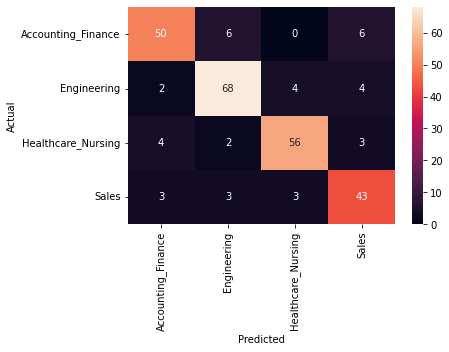

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

categories = sorted(list(set(labels))) # this gives sorted set of unique label names

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categories, yticklabels=categories) # creates a heatmap from the confusion matrix
plt.ylabel('Actual')
plt.xlabel('Predicted')

Oh, and indeed, there is another handy function named `plot_confusion_matrix` that can be used to visually represent a confusion matrix, which creates the following visual confusion matrix with and without normalization. 
Refer to the API [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix), it takes:
* the built ML model for classification
* the data features of the test set
* the lables of the test set

and visually displays the confusion matrix. 
There are two different ways to show the confusion matrix, one is showing the raw number of mis-classifications, the other is showning the normalized percentage.
Following code tries both options:

Confusion matrix, without normalization
[[50  6  0  6]
 [ 2 68  4  4]
 [ 4  2 56  3]
 [ 3  3  3 43]]
Normalized confusion matrix
[[0.80645161 0.09677419 0.         0.09677419]
 [0.02564103 0.87179487 0.05128205 0.05128205]
 [0.06153846 0.03076923 0.86153846 0.04615385]
 [0.05769231 0.05769231 0.05769231 0.82692308]]


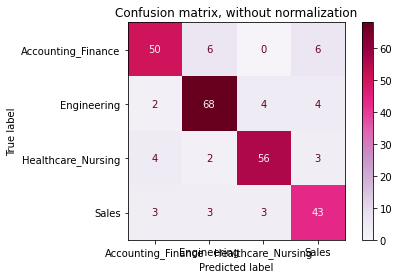

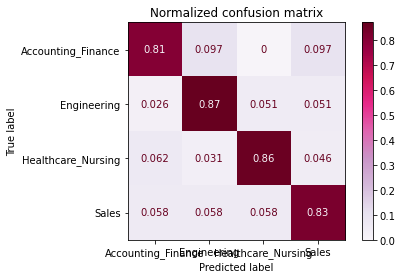

In [57]:
from sklearn.metrics import plot_confusion_matrix


titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')] # titles of different versions of the confusion matrix

for title, normalize in titles_options: # for each option, creates the confusion matrix visualzation
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=categories,
                                 cmap=plt.cm.PuRd,
                                 normalize=normalize) # create the plot object
    disp.ax_.set_title(title) # attach the title to the plot

    # prints the title and actual confusion matrix
    print(title) 
    print(disp.confusion_matrix)

plt.show() # shows the plots

Then, to dive into these mis-classification cases, we can simply print out the actual text to have a look. 

We first need to read the saved .txt files:

In [58]:
txt_fname = 'description.txt'
with open(txt_fname) as txtf:
    article_txts = txtf.read().splitlines() # reading a list of strings, each for a document/article

In [59]:
len(article_txts) # there should be in total 2225 articles

776

The following code then prints each of the mis-classification cases for categories that we have mis-classified more than twice.
Note that in the following we have re-used variables that we created before:
* test_indices: we created this when we do the train test split. This list stores the list of indices in the dataset for which the element of that indices is selected as a member of the test set.


In [60]:
num_cat = len(categories) # number of unique categories/labels, we have 5 in this example
for p_ind in range(0, num_cat):
    for a_ind in range(0, num_cat):
        if categories[p_ind] !=  categories[a_ind] and conf_mat[a_ind, p_ind] >= 2: # we only print out those we have mis-classified for at least 2 instances
            print("'{}' predicted as '{}' : {} examples.".format(categories[a_ind], categories[p_ind],\
                                                                 conf_mat[a_ind, p_ind]))
            print("====================================================")
            
            # retrieve the indices for the mis-classification
            mis_inds = [test_indices[i] for i in range(0,len(y_test)) if \
                        y_pred[i] == categories[p_ind] and y_test[i] == categories[a_ind]]
            
            #print out the article ID and the tokenised text content of the mis-classified examples
            for ind in mis_inds:
                print("----------------Article ID: ",article_ids[ind],"----------------")
                print(article_txts[ind])
                print("-----------------------------------------------\n")
            print()
            

'Engineering' predicted as 'Accounting_Finance' : 2 examples.
----------------Article ID:  70322392 ----------------
production coordinator sandbach salary pound ndash client rsquo experts supplying tailored refrigeration control solutions niche markets supermarkets industrial refrigeration plants client established company years contracting past years set expand nbsp nbsp due restructuring client production coordinator join small friendly team based sandbach nbsp nbsp nbsp nbsp nbsp nbsp nbsp nbsp nbsp nbsp nbsp production coordinator ndash role requirements successful candidate manage administrative tasks relating production activities meet company targets order input company crm system nbsp include regular telesales contact build strong working relationships clients suppliers raising purchase orders suppliers prioritising work load answering client queries email telephone internal external research information awareness stock control procedures assist stock audits perform clerical d

This is consistent with the accuracy claculated by `accuracy_score` too &#128522;

So, the above has built a logistic regression model based on the `binary_features` (i.e. binary vector representations of documents), in the following, we will continue to do the same thing for other vector representations:
- count_features
- tfidf_features

We can then compare the accuarcy results of different representation.

### 2.2 Classification Model Based on Count Vector Representation

The following code builds a logistic regression model based on the count vector representation, apply on the test data, and report the accuracy score:

In [61]:
X_train, X_test, y_train, y_test = train_test_split(count_features, labels, test_size=0.33, random_state=seed)
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.867704280155642

In [62]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, labels, test_size=0.33, random_state=seed)
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8638132295719845

Interesting, from the above experiements, binary and count features achieved the same accuracy scores, and tfidf features achieved slightly lower scores. 
Changing the `seek` values might gives you different numbers, you should definitely try a few &#128522;
Since there are randomness involved in both the process of splitting the training and testing data, as well as when we train the models, we'd better repeat the experiments a couple of times in different settings to get more robust results. 

To do this, we can do [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). You should refer to [2] for an introduction on k-fold cross validation and understand the rationale of it. :)



In [63]:
from sklearn.model_selection import KFold
num_folds = 5
kf = KFold(n_splits= num_folds, random_state=seed, shuffle = True) # initialise a 5 fold validation
print(kf)

KFold(n_splits=5, random_state=3879312, shuffle=True)


In [64]:
def evaluate(X_train,X_test,y_train, y_test,seed):
    model = LogisticRegression(random_state=seed)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [65]:
num_models = 3
cv_df = pd.DataFrame(columns = ['binary','count','tfidf'],index=range(num_folds)) # creates a dataframe to store the accuracy scores in all the folds

fold = 0
for train_index, test_index in kf.split(list(range(0,len(labels)))):
    y_train = [labels[i] for i in train_index]
    y_test = [labels[i] for i in test_index]

    X_train_binary, X_test_binary = binary_features[train_index], binary_features[test_index]
    cv_df.loc[fold,'binary'] = evaluate(binary_features[train_index],binary_features[test_index],y_train,y_test,seed)
    
    X_train_count, X_test_count = count_features[train_index], count_features[test_index]
    cv_df.loc[fold,'count'] = evaluate(count_features[train_index],count_features[test_index],y_train,y_test,seed)

    X_train_tfidf, X_test_tfidf = tfidf_features[train_index], tfidf_features[test_index]
    cv_df.loc[fold,'tfidf'] = evaluate(tfidf_features[train_index],tfidf_features[test_index],y_train,y_test,seed)
    
    fold +=1

In [66]:
cv_df

,binary,count,tfidf
0,0.833333,0.858974,0.858974
1,0.896774,0.890323,0.903226
2,0.890323,0.890323,0.890323
3,0.890323,0.896774,0.916129
4,0.870968,0.883871,0.929032


We can then measure the average accuracy scores over all the folds:

In [67]:
cv_df.mean()

binary    0.876344
count     0.884053
tfidf     0.899537
dtype: float64

Oh, it appears that in this experiement, tfdf vector representations do achieved slightly (oh, very slightly &#129322;) higher accuracy overall. 

## Summary

In this activity, we have demonstrated how to build a simple logistic regression model for document classification, using the data features we created in our last activity, namely, binary, count, and tfidf vector representation of documents. 
A few message to take away:
* it is not guaranteed that a more sohpicated model (e.g. the one built by tfidf vectors) can produced higher accuracy. See in some of our previous examples, binary and count might produce a higher score with a particular seed. 
* there are randomness that could happen in train-test split and in model bulding as well, so to make the result reproducible, remember to set a seed.
* since there are randomness involved, it's more robust to validate a few times, and cross-validate is a common validation framework we can adopt to get more robust results.

Overall, we hope you have a lot of fun doing this activity!!! &#129322;

## References and Prescribed Readings
[1] [Problem-solving with ML: automatic document classification](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification) -- by Ahmed Kachkach  
[2] [A Gentle Introduction to k-fold Cross-Validation](https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20a%20resampling,k%2Dfold%20cross%2Dvalidation.)  -- by Jason Brownlee